## 1 Autoencoder

In [28]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [30]:
from keras.datasets import fashion_mnist
import numpy as np

(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

In [32]:
from keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 107s 2ms/step - loss: 0.3055 - val_loss: 0.3068
Epoch 2/10
60000/60000 [==============================] - 105s 2ms/step - loss: 0.3033 - val_loss: 0.3012
Epoch 3/10
60000/60000 [==============================] - 103s 2ms/step - loss: 0.3016 - val_loss: 0.3007
Epoch 4/10
60000/60000 [==============================] - 112s 2ms/step - loss: 0.3000 - val_loss: 0.3027
Epoch 5/10
60000/60000 [==============================] - 107s 2ms/step - loss: 0.2985 - val_loss: 0.2996
Epoch 6/10
60000/60000 [==============================] - 106s 2ms/step - loss: 0.2974 - val_loss: 0.2966
Epoch 7/10
60000/60000 [==============================] - 107s 2ms/step - loss: 0.2959 - val_loss: 0.2996
Epoch 8/10
60000/60000 [==============================] - 107s 2ms/step - loss: 0.2950 - val_loss: 0.2950
Epoch 9/10
60000/60000 [==============================] - 106s 2ms/step - loss: 0.2945 - val_loss: 0.2

<Figure size 1440x288 with 0 Axes>

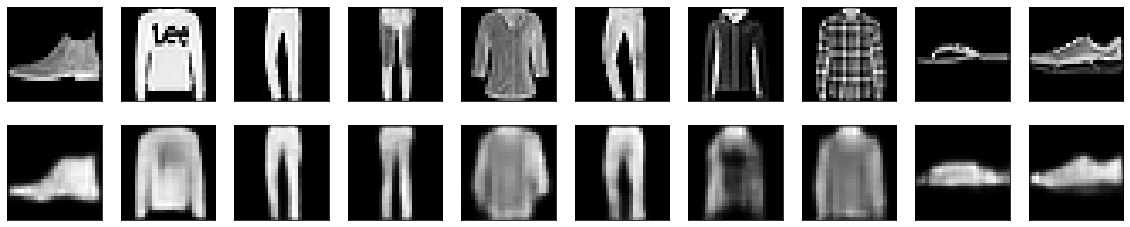

In [38]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## 2 Image Classification
### 2.1 Deep CNN

Build a deep CNN with 3 hidden layers: two 2D convolution layers, each followed by a 2 $\times$ 2 maxpooling layer and a 0.3 dropout regularization operation, and a dense layer. The two convolution layers' output is passed to a flatten layer, the dense layer with 64 units, a 0.5 dropout regularization and finally to a softmax output layer that predicts 10 categories. The two 2D convolution layers both have 3 $\times$ 3 kernels with a stride of 1. No padding is used.

In [21]:
import numpy as np
import keras
from keras import layers
from keras import models
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score

In [78]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [82]:
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [41]:
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1))) 
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

In [42]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 11, 11, 32)        18464     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 800)               0         
__________

In [43]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=5, batch_size=64)

Epoch 1/5
60000/60000 [==============================] - 49s 823us/step - loss: 0.7422 - acc: 0.7326
Epoch 2/5
60000/60000 [==============================] - 48s 798us/step - loss: 0.4998 - acc: 0.8222
Epoch 3/5
60000/60000 [==============================] - 48s 803us/step - loss: 0.4453 - acc: 0.8421
Epoch 4/5
60000/60000 [==============================] - 50s 830us/step - loss: 0.4166 - acc: 0.8547
Epoch 5/5
60000/60000 [==============================] - 48s 803us/step - loss: 0.4004 - acc: 0.86160s - loss: 0.4004 - acc: 0.861


In [46]:
print("The model's accuracy score on training set:\n")
score_train = model.evaluate(train_images, train_labels, verbose=0)
print(score_train[1])
print("The model's accuracy score on test set:\n")
score_test = model.evaluate(test_images, test_labels, verbose=0)
print(score_test[1])

The model's accuracy score on training set:

0.8922833333333333
The model's accuracy score on test set:

0.8829


### 2.2 Transfer Learning

In [79]:
from keras.applications import VGG16

In [80]:
conv_base = VGG16(weights = 'imagenet', include_top = False, input_shape = (48,48,3))
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0         
__________

In [81]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))

# Freeze the convolutional base
print('This is the number of trainable weights before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('This is the number of trainable weights after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30
This is the number of trainable weights after freezing the conv base: 4


In [85]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_13 (Flatten)         (None, 512)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 64)                32832     
_________________________________________________________________
dropout_13 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 10)                650       
Total params: 14,748,170
Trainable params: 33,482
Non-trainable params: 14,714,688
_________________________________________________________________


In [83]:
train_images = np.array(list(map(lambda x: np.resize(x, (48,48,3)), train_images)))
train_images.shape
#train_images = np.array(list(map(lambda x: np.resize(x, (48,48,3)), t_images)))

(60000, 48, 48, 3)

In [86]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=5, batch_size=64)

Epoch 1/5
60000/60000 [==============================] - 1007s 17ms/step - loss: 1.0598 - acc: 0.6240
Epoch 2/5
60000/60000 [==============================] - 1001s 17ms/step - loss: 0.8715 - acc: 0.6908
Epoch 3/5
60000/60000 [==============================] - 1001s 17ms/step - loss: 0.8266 - acc: 0.7082
Epoch 4/5
60000/60000 [==============================] - 1001s 17ms/step - loss: 0.7985 - acc: 0.7198
Epoch 5/5
60000/60000 [==============================] - 1001s 17ms/step - loss: 0.7833 - acc: 0.7254


In [89]:
print("The model's accuracy score on training set:\n")
score_train = model.evaluate(train_images, train_labels, verbose=0)
print(score_train[1])
print("The model's accuracy score on test set:\n")
test_images = np.array(list(map(lambda x: np.resize(x, (48,48,3)), test_images)))
score_test = model.evaluate(test_images, test_labels, verbose=0)
print(score_test[1])

The model's accuracy score on training set:

0.7617333333333334
The model's accuracy score on test set:

0.7513


The transfer learning model here falls short of the previous deep CNN in terms of accuracy, probably because the model is fitted on only five epochs.

## 3 Text Classification
### 3.1 RNN

In [1]:
# --- Libraries ---
# - Base libs -
import os
import numpy as np
import pandas as pd

# - Data Preprocessing libs -
import nltk

# - Keras libs -
from keras.models import Sequential
from keras.layers import Dense, Embedding, SimpleRNN, LSTM, GRU, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import TensorBoard, ModelCheckpoint

# -Plot libs-
import matplotlib.pyplot as plt
from IPython.display import SVG, display
#%matplotlib inline

# -- ROC libs --
from sklearn.metrics import roc_curve, auc

/Users/yimengxu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# --- Set base path ---
cwd = os.getcwd()

In [3]:
benign = pd.read_csv("https://s3.amazonaws.com/anly-590/url-classification/benign-urls.txt")
mal = pd.read_csv("https://s3.amazonaws.com/anly-590/url-classification/malicious-urls.txt", names = ["# GOOGLE"])

In [4]:
# --- Preprocess Data ---
# Create a character index for each of the character in each URL
# The index of a given character is determined by its frequency 
# in both the benign and the mal URL dataset
charALL = [l.lower() for w in benign['# GOOGLE'] for l in w] + [l.lower() for w in mal['# GOOGLE'] for l in w]
lookup = {j[0]:i for i,j in enumerate(nltk.FreqDist(charALL).most_common())}

# Convert each of the URL into a vector
# The element of the vector is the character index calculated above,
# which is the rank of frequency
dataBN = []
for row in benign['# GOOGLE']:
     dataBN.append([lookup[i.lower()] for i in row])
dataBN = np.array(dataBN)
dataMAL = []
for row in mal['# GOOGLE']:
    dataMAL.append([lookup[i.lower()] for i in row])
dataMAL = np.array(dataMAL)

In [5]:
# Count the total number of unique characters in all URLs
charBN = set([l.lower() for w in benign['# GOOGLE'] for l in w])
charMAL = set([l.lower() for w in mal['# GOOGLE'] for l in w])
num_char = len(charBN.union(charMAL))

# Max number of characters
max_features = num_char

# Max length of URL
URL_len = [len(u) for u in benign['# GOOGLE']]
URL_len = URL_len + [len(u) for u in mal['# GOOGLE']]
#max(URL_len)
maxlen = 100

# Max number of comments read in at at ime
batch_size = 64

# Pad the vectors to have the same length
from keras.preprocessing import sequence
dataBN = sequence.pad_sequences(dataBN, maxlen = maxlen)
dataMAL = sequence.pad_sequences(dataMAL, maxlen = maxlen)

In [6]:
# Combine the benign URLs and malicious URLs
X = np.concatenate((dataBN, dataMAL), 0)
#X

In [7]:
# Create labels for the URLs
yBN = np.full((dataBN.shape[0]), fill_value = 0, dtype = int)
yMAL = np.full((dataMAL.shape[0]), fill_value = 1, dtype = int)
y = np.concatenate((yBN, yMAL),0)
#y

In [8]:
X.shape

(67352, 100)

In [9]:
y.shape

(67352,)

In [10]:
# --- Separate training and test set --
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 32)
#X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5, random_state = 45)

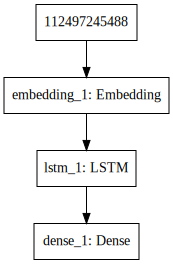

In [11]:
# --- Training model: Embedding + RNN LSTM---
model = Sequential()
model.add(Embedding(max_features, 32))
#model.add(SimpleRNN(32))
#model.add(GRU(32))
model.add(LSTM(32))
model.add(Dense(1, activation ='sigmoid'))

# --- Visualizing the model ---
show_model_now = True
if (show_model_now):
    display(SVG(model_to_dot(model).create(prog='dot', format='svg')))
else:
    # saves model in directory
    plot_model(model,
               to_file=os.path.join(cwd,'model.png'))

In [12]:
# --- Locations to save model ---
save_path_model = os.path.join(cwd,'rnn_model.h5')

# --- Compile Model ---
#Compile model
model.compile(optimizer = 'rmsprop',
             loss = 'binary_crossentropy',
             metrics=['acc'])

# If we want to checkpoint our model so we don't rerun it
checkpointer = ModelCheckpoint(filepath=save_path_weights, 
                               verbose=1, save_best_only=True)


# Verbose=0 -> to avoid jupyter notebook freezing
history = model.fit(X_train, y_train, 
                    epochs = 5, batch_size = 128, 
                    validation_split = 0.2,verbose=1)

Train on 43104 samples, validate on 10777 samples
Epoch 1/5
43104/43104 [==============================] - 79s 2ms/step - loss: 0.0966 - acc: 0.9789 - val_loss: 0.0636 - val_acc: 0.9821
Epoch 2/5
43104/43104 [==============================] - 77s 2ms/step - loss: 0.0674 - acc: 0.9806 - val_loss: 0.0561 - val_acc: 0.9823
Epoch 3/5
43104/43104 [==============================] - 79s 2ms/step - loss: 0.0616 - acc: 0.9808 - val_loss: 0.0513 - val_acc: 0.9830
Epoch 4/5
43104/43104 [==============================] - 79s 2ms/step - loss: 0.0724 - acc: 0.9806 - val_loss: 0.0544 - val_acc: 0.9827
Epoch 5/5
43104/43104 [==============================] - 79s 2ms/step - loss: 0.0526 - acc: 0.9812 - val_loss: 0.0469 - val_acc: 0.9832


In [13]:
# --- Save Model ---
# Saves as an HDF5 file
model.save(save_path_model)

In [14]:
# --- Loading the model ---
#from keras.models import load_model
#model = load_model(save_path_model)

In [19]:
# --- Calculate FPR, TPR and AUC for RNN model ---
y_pred = model.predict(X_test).ravel()
fpr_rnn, tpr_rnn, thresholds_rnn = roc_curve(y_test, y_pred)
auc_rnn = auc(fpr_rnn, tpr_rnn)

### 3.2 CNN

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 128)          5504      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 94, 32)            28704     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 18, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 12, 32)            7200      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 41,441
Trainable params: 41,441
Non-trainable params: 0
_________________________________________________________________


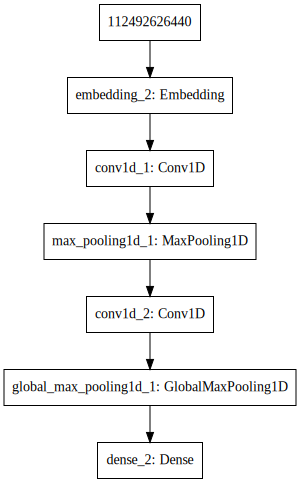

In [23]:
model = Sequential()
model.add(Embedding(max_features, 128, input_length=maxlen))
model.add(Conv1D(32, 7, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(32, 7, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1))
model.summary()
# -- Visualize the model --
show_model_now = True
if (show_model_now):
    display(SVG(model_to_dot(model).create(prog='dot', format='svg')))
else:
    # saves model in directory
    plot_model(model,
               to_file=os.path.join(cwd,'model.png'))

In [24]:
# --- Locations to save model ---
save_path_model = os.path.join(cwd,'cnn_model.h5')

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

# If we want to checkpoint our model so we don't rerun it
checkpointer = ModelCheckpoint(filepath=save_path_weights, 
                               verbose=1, save_best_only=True)

history = model.fit(X_train, y_train,
                    epochs=5,
                    batch_size=128,
                    validation_split=0.2, verbose = 1)

# --- Save Model ---
# Saves as an HDF5 file
model.save(save_path_model)

# --- Loading the model ---
#from keras.models import load_model
#model = load_model(save_path_model)

Train on 43104 samples, validate on 10777 samples
Epoch 1/5
43104/43104 [==============================] - 19s 450us/step - loss: 0.0750 - acc: 0.9772 - val_loss: 0.0529 - val_acc: 0.9705
Epoch 2/5
43104/43104 [==============================] - 17s 404us/step - loss: 0.0572 - acc: 0.9026 - val_loss: 0.0733 - val_acc: 0.4882
Epoch 3/5
43104/43104 [==============================] - 19s 430us/step - loss: 0.0653 - acc: 0.5037 - val_loss: 0.0526 - val_acc: 0.6304
Epoch 4/5
43104/43104 [==============================] - 19s 445us/step - loss: 0.0534 - acc: 0.4219 - val_loss: 0.0659 - val_acc: 0.3161
Epoch 5/5
43104/43104 [==============================] - 19s 442us/step - loss: 0.0491 - acc: 0.3414 - val_loss: 0.0532 - val_acc: 0.3204


In [25]:
# --- Calculate FPR, TPR and AUC for 1D CNN model ---
y_pred = model.predict(X_test).ravel()
fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(y_test, y_pred)
auc_cnn = auc(fpr_cnn, tpr_cnn)

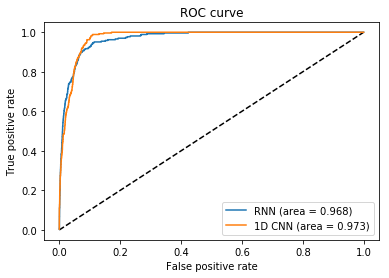

In [27]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rnn, tpr_rnn, label='RNN (area = {:.3f})'.format(auc_rnn))
plt.plot(fpr_cnn, tpr_cnn, label='1D CNN (area = {:.3f})'.format(auc_cnn))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

The RNN and 1D CNN both perform well on the benign vs malicious URL classification. The 1D CNN model has a slightly better AUC than the RNN model and runs faster. RNN beats 1D CNN at first by a slightly higher TPR given a FPR but 1D CNN quickly catch up with RNN and reaches the optimum earlier than RNN.